# BayesNF Test

In [44]:
import jax
jax.default_backend()

'cpu'

In [45]:
## -----------------------
## Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import datetime
from sklearn import ensemble
import rbf_utils


In [46]:
## -----------------------
## Prep grid (mostly for bounds)
grid_gdf = gpd.read_file("./data/coarse_grid_pts/grid_pts_coarse.shp")
grid_gdf = grid_gdf.set_crs(4326, allow_override=True)
grid_gdf = grid_gdf.to_crs(32612)

## Grid min/max (replaced by set limits below)
grid_crds = grid_gdf.get_coordinates()
min_x = grid_crds.x.min()
max_x = grid_crds.x.max()
min_y = grid_crds.y.min()
max_y = grid_crds.y.max()

## Updated to help estimate of basis functions
min_x = 393500
max_x = 453500
min_y = 4472000
max_y = 4532000
print(min_x, max_x, min_y, max_y)



393500 453500 4472000 4532000


In [47]:
## -----------------------
## Air monitor data
aq_df = pd.read_csv("./data/loop_test/summer23_ozone_stationary.csv")
aq_df['day_time'] = pd.to_datetime(aq_df['day_time']).dt.tz_localize(None)
## add the timezone:
aq_df['day_time'] = aq_df['day_time'] + pd.Timedelta(hours=7)


In [48]:
aq_df.head(10)

,site.num,latitude,longitude,parameter.name,day_time,date,hour,sample.measurement
0,2005,40.598056,-111.894167,Ozone,2023-06-01 07:00:00,2023-06-01,0S,0.044
1,2005,40.598056,-111.894167,Ozone,2023-06-01 08:00:00,2023-06-01,1H 0M 0S,0.034
2,2005,40.598056,-111.894167,Ozone,2023-06-01 09:00:00,2023-06-01,2H 0M 0S,0.030
3,2005,40.598056,-111.894167,Ozone,2023-06-01 10:00:00,2023-06-01,3H 0M 0S,0.031
4,2005,40.598056,-111.894167,Ozone,2023-06-01 11:00:00,2023-06-01,4H 0M 0S,0.023
5,2005,40.598056,-111.894167,Ozone,2023-06-01 12:00:00,2023-06-01,5H 0M 0S,0.019
6,2005,40.598056,-111.894167,Ozone,2023-06-01 13:00:00,2023-06-01,6H 0M 0S,0.018
7,2005,40.598056,-111.894167,Ozone,2023-06-01 14:00:00,2023-06-01,7H 0M 0S,0.025
8,2005,40.598056,-111.894167,Ozone,2023-06-01 15:00:00,2023-06-01,8H 0M 0S,0.038
9,2005,40.598056,-111.894167,Ozone,2023-06-01 16:00:00,2023-06-01,9H 0M 0S,0.049


In [49]:
## Convert to geopandas
aq_gdf = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(aq_df.longitude, aq_df.latitude, crs="EPSG:4326"), data=aq_df
)
aq_gdf = aq_gdf.to_crs(32612)

## Standardize coordinates
aq_crds = aq_gdf.get_coordinates()
lon = aq_crds.x
lat = aq_crds.y
# aq_df['normalized_east'] = (lon-min_x)/(max_x - min_x)
# aq_df['normalized_north'] = (lat-min_y)/(max_y-min_y)
# aq_df['east'] = aq_crds.x / 1e3
# aq_df['north'] = aq_crds.y / 1e3

aq_df['east'] = (lon-min_x)/(max_x - min_x)
aq_df['north'] = (lat-min_y)/(max_y-min_y)


In [50]:
aq_df.head(10)

,site.num,latitude,longitude,parameter.name,day_time,date,hour,sample.measurement,east,north
0,2005,40.598056,-111.894167,Ozone,2023-06-01 07:00:00,2023-06-01,0S,0.044,0.514062,0.375387
1,2005,40.598056,-111.894167,Ozone,2023-06-01 08:00:00,2023-06-01,1H 0M 0S,0.034,0.514062,0.375387
2,2005,40.598056,-111.894167,Ozone,2023-06-01 09:00:00,2023-06-01,2H 0M 0S,0.030,0.514062,0.375387
3,2005,40.598056,-111.894167,Ozone,2023-06-01 10:00:00,2023-06-01,3H 0M 0S,0.031,0.514062,0.375387
4,2005,40.598056,-111.894167,Ozone,2023-06-01 11:00:00,2023-06-01,4H 0M 0S,0.023,0.514062,0.375387
5,2005,40.598056,-111.894167,Ozone,2023-06-01 12:00:00,2023-06-01,5H 0M 0S,0.019,0.514062,0.375387
6,2005,40.598056,-111.894167,Ozone,2023-06-01 13:00:00,2023-06-01,6H 0M 0S,0.018,0.514062,0.375387
7,2005,40.598056,-111.894167,Ozone,2023-06-01 14:00:00,2023-06-01,7H 0M 0S,0.025,0.514062,0.375387
8,2005,40.598056,-111.894167,Ozone,2023-06-01 15:00:00,2023-06-01,8H 0M 0S,0.038,0.514062,0.375387
9,2005,40.598056,-111.894167,Ozone,2023-06-01 16:00:00,2023-06-01,9H 0M 0S,0.049,0.514062,0.375387


In [51]:
i = "2023-06-07"
print("## -------------- ##")
print(f"Running for {i}")
target_date = pd.to_datetime(i)
start_date = target_date - pd.to_timedelta(7, unit='d')

## ------------------------------------------------------------------------
## Extract monitor data
print("Prepping monitor data")
start_date_train = target_date - pd.to_timedelta(7, unit='d')
stop_date_train = target_date + pd.to_timedelta(1, unit='d')
aq_df_sub = aq_df[(aq_df['day_time'] >= start_date_train) & (aq_df['day_time'] < stop_date_train)].copy()

# day_time = aq_df_sub['day_time'].astype('int64') / 1e9 ## Time in nanoseconds
# min_t = day_time.min()
# max_t = day_time.max()
# aq_df_sub['normalized_time'] = (day_time - min_t) / (max_t-min_t)
print(f'Subset: {aq_df_sub.shape}')
aq_df_sub.head(10)

## -------------- ##
Running for 2023-06-07
Prepping monitor data
Subset: (1280, 10)


,site.num,latitude,longitude,parameter.name,day_time,date,hour,sample.measurement,east,north
0,2005,40.598056,-111.894167,Ozone,2023-06-01 07:00:00,2023-06-01,0S,0.044,0.514062,0.375387
1,2005,40.598056,-111.894167,Ozone,2023-06-01 08:00:00,2023-06-01,1H 0M 0S,0.034,0.514062,0.375387
2,2005,40.598056,-111.894167,Ozone,2023-06-01 09:00:00,2023-06-01,2H 0M 0S,0.030,0.514062,0.375387
3,2005,40.598056,-111.894167,Ozone,2023-06-01 10:00:00,2023-06-01,3H 0M 0S,0.031,0.514062,0.375387
4,2005,40.598056,-111.894167,Ozone,2023-06-01 11:00:00,2023-06-01,4H 0M 0S,0.023,0.514062,0.375387
5,2005,40.598056,-111.894167,Ozone,2023-06-01 12:00:00,2023-06-01,5H 0M 0S,0.019,0.514062,0.375387
6,2005,40.598056,-111.894167,Ozone,2023-06-01 13:00:00,2023-06-01,6H 0M 0S,0.018,0.514062,0.375387
7,2005,40.598056,-111.894167,Ozone,2023-06-01 14:00:00,2023-06-01,7H 0M 0S,0.025,0.514062,0.375387
8,2005,40.598056,-111.894167,Ozone,2023-06-01 15:00:00,2023-06-01,8H 0M 0S,0.038,0.514062,0.375387
9,2005,40.598056,-111.894167,Ozone,2023-06-01 16:00:00,2023-06-01,9H 0M 0S,0.049,0.514062,0.375387


In [52]:
df_train = aq_df_sub[aq_df_sub['site.num']!=2005]
df_test = aq_df_sub[aq_df_sub['site.num']==2005]

train_sites = df_train['site.num'].unique()
print(f'Training: {train_sites}')

test_sites = df_test['site.num'].unique()
print(f'Training: {test_sites}')

Training: [3006 3010 3013 3014 3015 3016 4002]
Training: [2005]


In [53]:
all_days = aq_df.date.unique()
len(all_days)

61

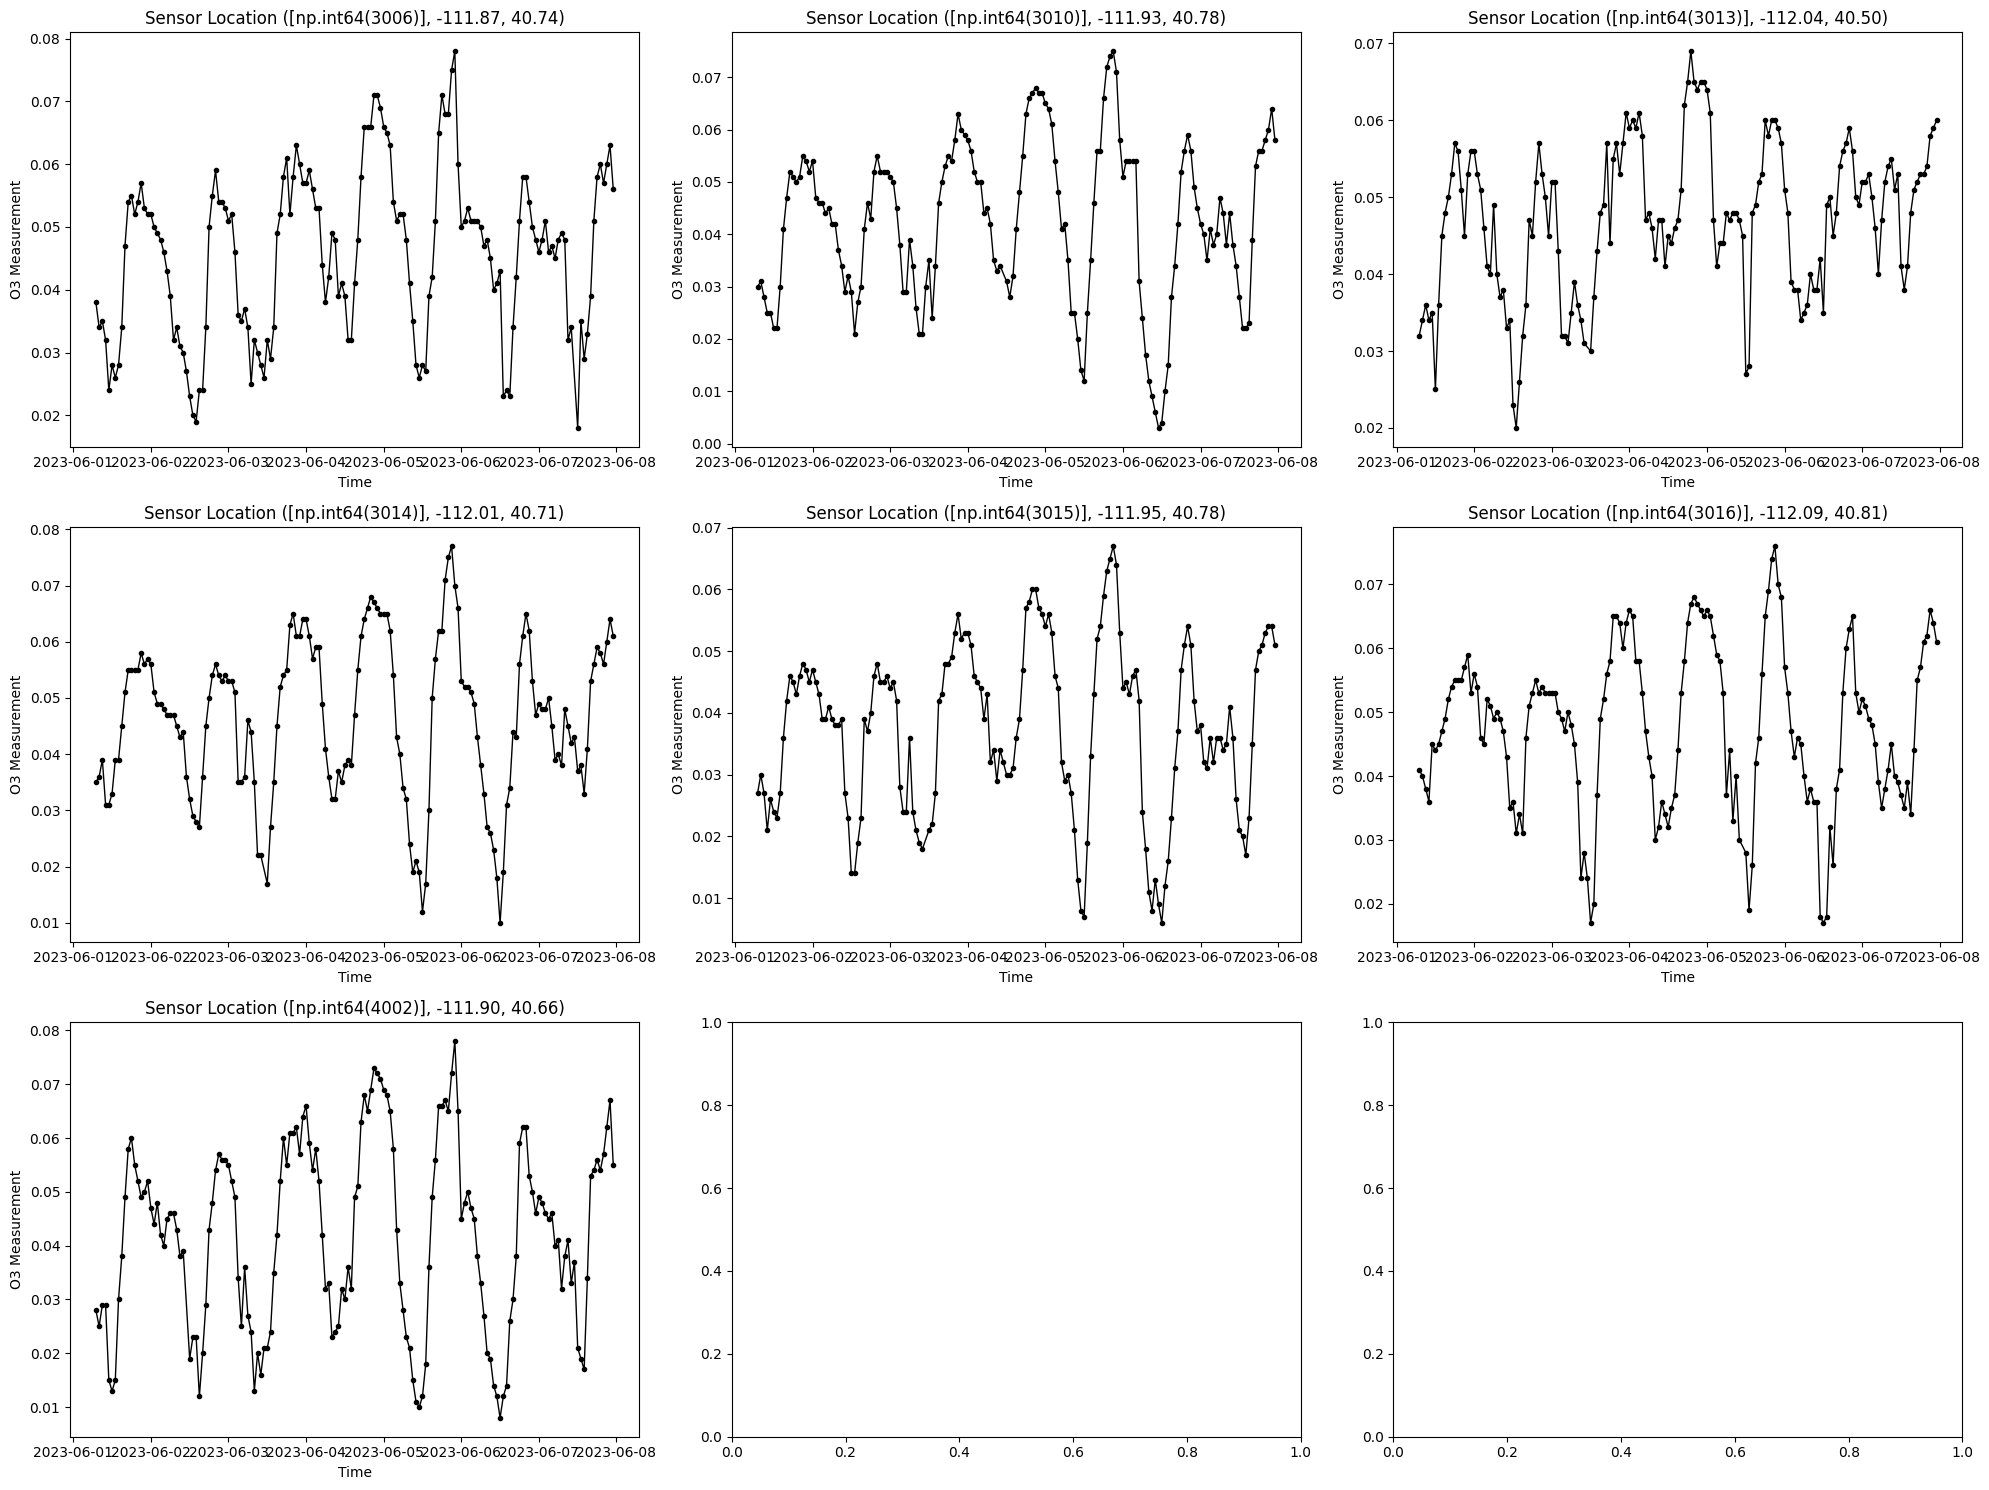

In [54]:
locations = df_train['site.num'].unique()
fig, axes = plt.subplots(ncols=3, nrows=3, tight_layout=True, figsize=(20,15))
for ax, location in zip(axes.flat, locations):
  df_location = df_train[df_train['site.num']==location]
  latitude, longitude = df_location.iloc[0][['latitude', 'longitude']]
  site_num = df_location.iloc[0][['site.num']].values
  ax.plot(df_location['day_time'], df_location['sample.measurement'], marker='.', color='k', linewidth=1)
  ax.set_title(f'Sensor Location ({site_num}, {longitude:.2f}, {latitude:.2f})')
  ax.set_xlabel('Time')
  ax.set_ylabel('O3 Measurement')

In [55]:
from bayesnf.spatiotemporal import BayesianNeuralFieldMAP

model = BayesianNeuralFieldMAP(
  width=512,
  depth=2,
  freq='H',
  seasonality_periods=['D', 'W'], # Daily and weekly seasonality, same as [24, 24*7]
  num_seasonal_harmonics=[4, 4], # Four harmonics for each seasonal factor.
  feature_cols=['day_time', 'latitude', 'longitude'], # time, spatial 1, ..., spatial n
  target_col='sample.measurement',
  observation_model='NORMAL',
  timetype='index',
  standardize=['latitude', 'longitude'],
  )

In [56]:
5 // 2

2

In [57]:
df_train.shape

(1120, 10)

In [65]:
batch_size = 300

In [66]:
# Train MAP ensemble
model = model.fit(
    df_train,
    seed=jax.random.PRNGKey(0),
    ensemble_size=8,
    num_epochs=5000,
    batch_size=batch_size
    )

/opt/homebrew/Caskroom/miniforge/base/envs/bayesnf/lib/python3.10/site-packages/bayesnf/spatiotemporal.py:101: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  first_date = pd.to_datetime('2020-01-01').to_period(freq)
/opt/homebrew/Caskroom/miniforge/base/envs/bayesnf/lib/python3.10/site-packages/bayesnf/spatiotemporal.py:102: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  table[time_column] = table[time_column].dt.to_period(freq)
/opt/homebrew/Caskroom/miniforge/base/envs/bayesnf/lib/python3.10/site-packages/bayesnf/spatiotemporal.py:56: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  x = pd.date_range(y[0].start_time, y[-1].start_time).to_period(freq)


/var/folders/ql/nw995vq50pq3dlrxhk7mm4_40000gq/T/ipykernel_40134/117576538.py:3: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  losses = np.row_stack(model.losses_)


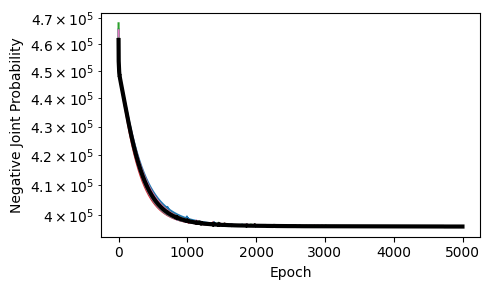

In [60]:
# Inspect the training loss for each particle.
import matplotlib.pyplot as plt
losses = np.row_stack(model.losses_)
fig, ax = plt.subplots(figsize=(5, 3), tight_layout=True)
ax.plot(losses.T)
ax.plot(np.mean(losses, axis=0), color='k', linewidth=3)
ax.set_xlabel('Epoch')
ax.set_ylabel('Negative Joint Probability')
ax.set_yscale('log', base=10)

In [61]:
yhat, yhat_quantiles = model.predict(df_test, quantiles=(0.025, 0.5, 0.975))

/opt/homebrew/Caskroom/miniforge/base/envs/bayesnf/lib/python3.10/site-packages/bayesnf/spatiotemporal.py:101: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  first_date = pd.to_datetime('2020-01-01').to_period(freq)
/opt/homebrew/Caskroom/miniforge/base/envs/bayesnf/lib/python3.10/site-packages/bayesnf/spatiotemporal.py:102: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  table[time_column] = table[time_column].dt.to_period(freq)
/opt/homebrew/Caskroom/miniforge/base/envs/bayesnf/lib/python3.10/site-packages/bayesnf/spatiotemporal.py:56: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  x = pd.date_range(y[0].start_time, y[-1].start_time).to_period(freq)


(array([ 5., 15., 17., 19., 12., 16., 17., 27., 20., 12.]),
 array([0.013 , 0.0187, 0.0244, 0.0301, 0.0358, 0.0415, 0.0472, 0.0529,
        0.0586, 0.0643, 0.07  ]),
 <BarContainer object of 10 artists>)

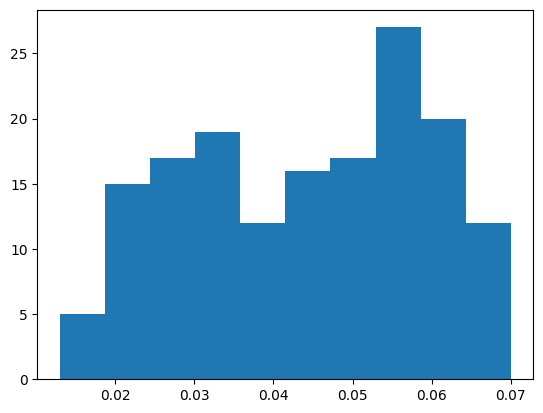

In [62]:
plt.hist(df_test['sample.measurement'])

Text(0, 0.5, 'Predicted Value')

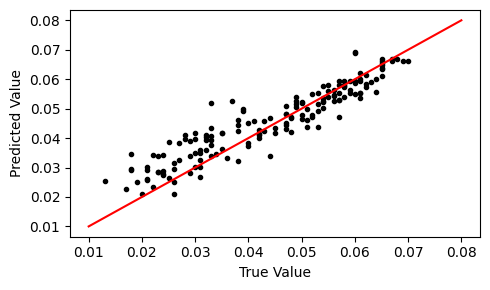

In [63]:
fig, ax = plt.subplots(figsize=(5,3), tight_layout=True)
ax.scatter(df_test['sample.measurement'], yhat_quantiles[1], marker='.', color='k')
ax.plot([0.01, 0.08], [0.01, 0.08], color='red')
ax.set_xlabel('True Value')
ax.set_ylabel('Predicted Value')

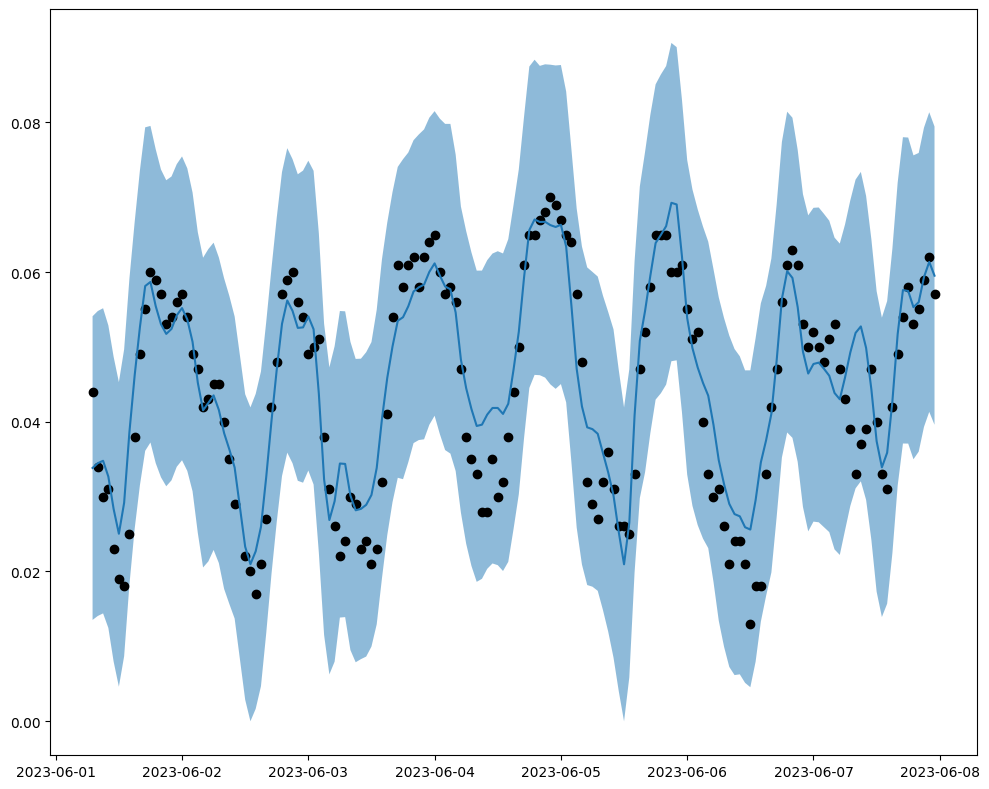

In [64]:
fig, ax = plt.subplots(figsize=(10,8), tight_layout=True)
ax.plot(df_test['day_time'], df_test['sample.measurement'], 'ko')
ax.plot(df_test['day_time'], yhat_quantiles[1])
ax.fill_between(df_test['day_time'], yhat_quantiles[0], yhat_quantiles[2], alpha=0.5, label='95% Prediction Interval')
